In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
df = pd.read_csv('linkedin_jobs.csv')


In [2]:
# standardize salaries to annual
def standardize_salary(row):
    """Convert all salaries to annual based on pay_period"""
    if pd.isna(row['pay_period']) or row['currency'] != 'USD':
        return pd.Series({'annual_min_salary': np.nan, 
                         'annual_med_salary': np.nan, 
                         'annual_max_salary': np.nan})
    
    # Define multipliers for different pay periods
    multipliers = {
        'HOURLY': 2080,  # 40 hours/week * 52 weeks
        'WEEKLY': 52,
        'MONTHLY': 12,
        'YEARLY': 1
    }
    
    mult = multipliers.get(row['pay_period'])
    if mult is None:  # Invalid pay period
        return pd.Series({'annual_min_salary': np.nan, 
                         'annual_med_salary': np.nan, 
                         'annual_max_salary': np.nan})
    
    min_sal = row['min_salary'] * mult if pd.notna(row['min_salary']) else np.nan
    max_sal = row['max_salary'] * mult if pd.notna(row['max_salary']) else np.nan
    med_sal = row['med_salary'] * mult if pd.notna(row['med_salary']) else np.nan
    
    # Calculate median if missing but min and max exist
    if pd.isna(med_sal) and pd.notna(min_sal) and pd.notna(max_sal):
        med_sal = (min_sal + max_sal) / 2
    
    return pd.Series({
        'annual_min_salary': min_sal,
        'annual_med_salary': med_sal,
        'annual_max_salary': max_sal
    })

print("=== Starting salary standardization ===")
print("Initial number of rows:", len(df))
print("Rows with USD currency:", len(df[df['currency'] == 'USD']))

# create annual salary columns
annual_salaries = df.apply(standardize_salary, axis=1)
df = pd.concat([df, annual_salaries], axis=1)


=== Starting salary standardization ===
Initial number of rows: 33246
Rows with USD currency: 13352


In [3]:

# Clean the dataset
# Keep only rows with at least one valid salary value and USD currency
df_clean = df[
    (df['currency'] == 'USD') & 
    (df[['annual_min_salary', 'annual_med_salary', 'annual_max_salary']].notna().any(axis=1))
]

# Remove rows with anual_med_salary < 10K or annual_max_salary > 5M
df_clean = df_clean[
    (df_clean['annual_med_salary'] >= 10000) & 
    (df_clean['annual_max_salary'] <= 5000000)
]

print("\n=== Cleaned Dataset Statistics ===")
print("Rows after cleaning:", len(df_clean))


=== Cleaned Dataset Statistics ===
Rows after cleaning: 11014


In [4]:
# Basic statistics of cleaned data
print("\nSalary Statistics (USD, Annual):")
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))
print(df_clean[['annual_min_salary', 'annual_med_salary', 'annual_max_salary']].describe())

# Experience level distribution
print("\nExperience Level Distribution:")
print(df_clean['formatted_experience_level'].value_counts(dropna=False))

# Location analysis (top 10)
print("\nTop 10 Locations:")
print(df_clean['location'].value_counts().head(10))

# Pay period distribution
print("\nPay Period Distribution:")
print(df_clean['pay_period'].value_counts(dropna=False))


Salary Statistics (USD, Annual):
       annual_min_salary  annual_med_salary  annual_max_salary
count          11,014.00          11,014.00          11,014.00
mean           84,774.30         100,694.99         116,615.69
std            46,051.68          57,060.58          72,263.36
min                42.00          12,500.00          15,000.00
25%            50,715.60          59,072.97          65,233.75
50%            75,000.00          89,634.61         100,000.00
75%           110,000.00         130,000.00         150,000.00
max           800,000.00       1,050,000.00       1,664,000.00

Experience Level Distribution:
Mid-Senior level    4150
NaN                 2822
Entry level         2181
Associate           1200
Director             481
Executive            110
Internship            70
Name: formatted_experience_level, dtype: int64

Top 10 Locations:
United States                      806
New York, NY                       524
Los Angeles, CA                    243
Seattle, 

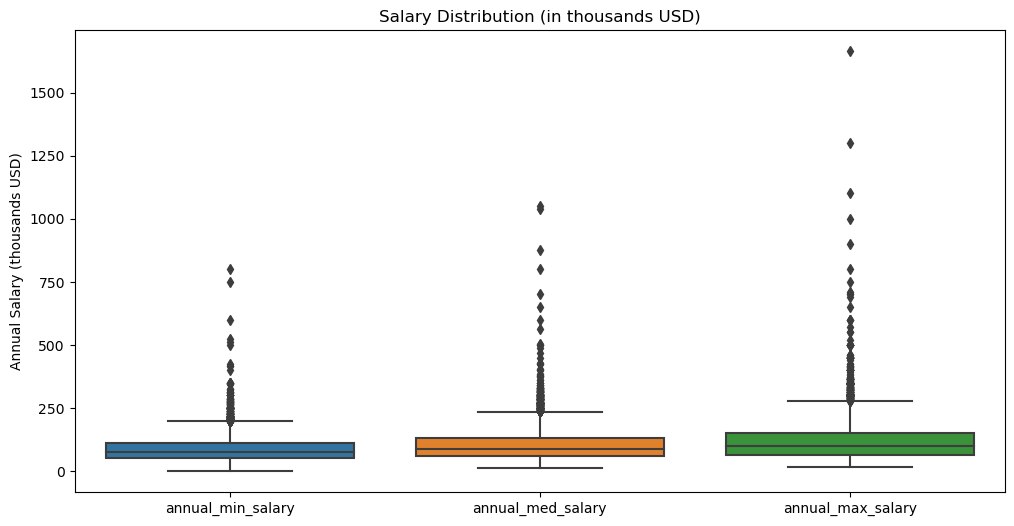

In [5]:

# Visualization
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean[['annual_min_salary', 'annual_med_salary', 'annual_max_salary']]/1000)
plt.title('Salary Distribution (in thousands USD)')
plt.ylabel('Annual Salary (thousands USD)')
plt.savefig('salary_distribution.png')


In [6]:

# Save preprocessed dataset
df_clean.to_csv('linkedin_jobs_preprocessed.csv', index=False)

print("\nPreprocessing complete. Preprocessed dataset saved as 'linkedin_jobs_preprocessed.csv'")


Preprocessing complete. Preprocessed dataset saved as 'linkedin_jobs_preprocessed.csv'
